In [2]:
import numpy as np

**FUNKCIJE**

In [107]:
def DMD(X, Y, tol=1e-12, k=-1):
    "k - ako znas koliko modova zelis"
    #X - Nxm, Y - Nxm
    m=X.shape[1]; N=X.shape[0]
    U, Sigma, V = np.linalg.svd(X,full_matrices=False) #svd vraca V*
    V=np.conjugate(V.T)
    #print(Sigma)
    if(k==-1):
        k=m
        for i in range(1,min(N,m)):
            if(Sigma[i]<=Sigma[0]*tol):
                k=i
                break
    U = U[:, :k]; V=V[:, :k]; Sigma = np.array(Sigma[:k])
    S_k = ((np.conjugate(U.T)@Y)@V)/Sigma
    Lambda, W = np.linalg.eig(S_k)
    Z = U@W
    return Z, Lambda


In [4]:
def DMD_exact(X, Y, tol=1e-12):
    """X - Nxm, Y - Nxm; !!Exact DMD ne vraća normirane Z[:,i]"""
    m=X.shape[1]; N=X.shape[0]
    U, Sigma, V = np.linalg.svd(X,full_matrices=False) #svd vraca V*
    V=np.conjugate(V.T)
    #print(Sigma)
    k=m
    for i in range(1,min(N,m)):
        if(Sigma[i]<=Sigma[0]*tol):
            k=i
            break
    U = U[:, :k]; V=V[:, :k]; Sigma = np.array(Sigma[:k])
    S_k = ((np.conjugate(U.T)@Y)@V)/Sigma
    Lambda, W = np.linalg.eig(S_k)
    Z = (Y@V/Sigma)@W/Lambda
    return Z, Lambda

In [5]:
def GEDMD(X, Y, tol=1e-12, type: str=None): 
    """
    type = "exact" if you want exact version, or None (/leave empty) if you don't want exact version. 
    Anything else set as type will do the non-exact version.
    """
    m=X.shape[1]; N=X.shape[0]
    D = np.linalg.norm(X, axis=0)
    X = X/D; Y=Y/D
    U, Sigma, V = np.linalg.svd(X,full_matrices=False) 
    V=np.conjugate(V.T)
    k=m
    for i in range(1,min(N,m)):
        if(Sigma[i]<=Sigma[0]*tol):
            k=i
            break
    U = U[:, :k]; V=V[:, :k]; Sigma = np.array(Sigma[:k])
    B_k = Y @ (V/Sigma)
    S_k = np.conjugate(U.T)@B_k
    Lambda, W = np.linalg.eig(S_k)
    Z = U@W
    if(type=="exact"):
        Z = B_k@W
    r = B_k@W - Z*Lambda
    return Z, Lambda, r

In [6]:
def GEDMDQ_multiple_trajectories(X, Y, tol=1e-12, type: str=None):
    """
    type = "exact" if you want exact version, or None (/leave empty) if you don't want exact version. 
    Anything else set as type will do the non-exact version.
    """
    m=X.shape[1];
    Q, R = np.linalg.qr(np.concatenate((X,Y), axis=1))
    Z, L, r = GEDMD(R[:,:m], R[:,m:], tol, type)
    Z = Q@Z
    return Z, L, r


In [7]:
def GEDMDQ(S, tol=1e-12, type: str=None):
    """
    type = "exact" if you want exact version, or None (/leave empty) if you don't want exact version. 
    Anything else set as type will do the non-exact version.
    """
    m=S.shape[1]-1;
    Q, R = np.linalg.qr(S)
    R_x = R[:(m+1),:m]; R_y = R[:(m+1), 1:(m+1)]
    Z, L, r = GEDMD(R_x, R_y, tol, type)
    Z = Q@Z
    return Z, L, r, Q, R

In [8]:
def DMD_added_snap(S, B, Q, R, tol=1e-12, type: str=None):
    m=S.shape[1]-1; N=S.shape[0]; b=B.shape[1]
    if(B.shape[0]!=N):
        return "new data doesn't have the same dimension as the old data"
    R_new= np.conjugate(Q.T)@B
    Q_1, R_1 = np.linalg.qr(B-Q@R_new)
    R_new=np.concatenate((R_new, R_1), axis=0)
    R = np.concatenate((R, np.zeros((b,m+1))), axis=0)
    R = np.concatenate((R, R_new), axis=1)
    Q = np.concatenate((Q, Q_1), axis=1)
    m=m+b
    R_x = R[:(m+1),:m]; R_y = R[:(m+1), 1:(m+1)] 
    Z, L, r = GEDMD(R_x, R_y, tol, type)
    Z=Q@Z
    return Z, L, r, Q, R


In [9]:
def householder_for_dmd(R, l):
    """R - matrix in trapezoidal form; 
    l - the amount of former dmd values discarded (also the number of sub-diagonals below the main one in R)"""
    N = R.shape[1]; N0 = R.shape[0]

    #l se moze iz oblika R procitat:
    #l=N0-N
    
    v_all=np.empty((l+1,N))


    #HH transf od R (trapezoidalna) 
    for i in range(N):
        element=R[i:(i+l+1),i]  
        v = element.copy().reshape(-1,1) #ako stavim v=element - pokazuju na istu memoriju; ne radi!!
        v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
        R[i:(i+l+1),i:] = R[i:(i+l+1),i:] - 2/(v.T@v)*v@(v.T@R[i:(i+l+1),i:])
        v_all[:,i] = v.reshape(-1)

    ##Q - from HH matrices
    hh_current = np.eye(N0, N0)
    v_current=v_all[:,-1].reshape(-1,1)
    hh_current[-l-1:,-l-1:] = np.eye(l+1,l+1)-2/(v_current.T@v_current)*(v_current@v_current.T)

    hh=hh_current #ovdje @ I

    for i in range(N-2,-1,-1):
        v_current = v_all[:,i].reshape(-1,1)
        hh_current = np.eye(l+1,l+1)-2/(v_current.T@v_current)*(v_current@v_current.T)
        hh[i:i+l+1, :] = hh_current@hh[i:i+l+1, :]
        #print(hh)


    return hh, R, v_all

In [10]:
def DMD_discarding_snap(l, Q, R, tol=1e-12, type: str=None):
    m=R.shape[0]
    hh, R, _ = householder_for_dmd(R[:,l:], l)
    R_x = R[:(m-l),:(m-l-1)]; R_y = R[:(m-l), 1:(m-l)]
    Z, L, r = GEDMD(R_x, R_y, tol, type)
    Q=Q[:,:m-l]
    Z=Q@Z
    return Z,L,r,Q, R, hh

**Umjetni primjer**

In [11]:
N=300
m=10
x=np.random.rand(N)
A=np.random.rand(N,N)
A = A/np.linalg.norm(A, 2)

In [12]:
X=np.empty((N,m+1))
X[:,0]=x
for i in range(m):
    X[:,i+1]=A@X[:,i]
X=X+np.random.rand(N,m+1)/N

In [13]:
Z, L = DMD(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)

L

array([ 0.99876213+0.j        ,  0.47547751+0.61309482j,
        0.47547751-0.61309482j, -0.02395529+0.70964774j,
       -0.02395529-0.70964774j,  0.07901611+0.j        ,
       -0.01704468+0.j        , -0.71870816+0.j        ,
       -0.55175137+0.49630947j, -0.55175137-0.49630947j])

In [14]:
#permutirani podaci - druge eigenvalues - kao što bi i očekivali!
print(X[:5,[1,6,8,9]])
temp=X[:,[1,6,8,9]]
X[:,[6,9]] = temp[:,[0,2]]
X[:,[1,8]] = temp[:,[1,3]]
print(X[:5,[1,6,8,9]])

Z_perm, L_perm = DMD(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)

L_perm


[[0.47028722 0.46868786 0.46761385 0.46629344]
 [0.46829101 0.45443124 0.45273912 0.45163679]
 [0.47346663 0.4770979  0.47658371 0.47409573]
 [0.47974416 0.46935699 0.4680554  0.46728535]
 [0.46475757 0.47964953 0.47812615 0.47722385]]
[[0.46868786 0.47028722 0.46629344 0.46761385]
 [0.45443124 0.46829101 0.45163679 0.45273912]
 [0.4770979  0.47346663 0.47409573 0.47658371]
 [0.46935699 0.47974416 0.46728535 0.4680554 ]
 [0.47964953 0.46475757 0.47722385 0.47812615]]


array([ 0.99890479+0.j        ,  0.57170665+0.58904146j,
        0.57170665-0.58904146j,  0.11501811+0.73293241j,
        0.11501811-0.73293241j,  0.00150469+0.j        ,
       -0.66299323+0.26536067j, -0.66299323-0.26536067j,
       -0.44615924+0.60775045j, -0.44615924-0.60775045j])

In [15]:
Ze, Le = DMD_exact(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)
Le
#isto kao L?

array([ 0.99890479+0.j        ,  0.57170665+0.58904146j,
        0.57170665-0.58904146j,  0.11501811+0.73293241j,
        0.11501811-0.73293241j,  0.00150469+0.j        ,
       -0.66299323+0.26536067j, -0.66299323-0.26536067j,
       -0.44615924+0.60775045j, -0.44615924-0.60775045j])

In [16]:
Zg, Lg, rg = GEDMD(X[:,:m], X[:,1:], N*np.finfo(float).resolution)
Lg

array([ 0.99890479+0.j        ,  0.57170665+0.58904146j,
        0.57170665-0.58904146j,  0.11501811+0.73293241j,
        0.11501811-0.73293241j,  0.00150469+0.j        ,
       -0.44615924+0.60775045j, -0.44615924-0.60775045j,
       -0.66299323+0.26536067j, -0.66299323-0.26536067j])

In [17]:
Z_qr, L_qr, r_qr, Q, R = GEDMDQ(X, N*np.finfo(float).resolution)
print(L_qr)

B = (A@X[:,m]+np.random.rand(N)/N).reshape((-1,1))

Z_added, L_added, r_added, _,_ = DMD_added_snap(X, B, Q, R, N*np.finfo(float).resolution)
print(L_added)

#provjera.. - dobije se isto
_,L_added_direct,_,_,_ = GEDMDQ(np.concatenate((X, B), axis=1), N*np.finfo(float).resolution)
print(L_added_direct)

print(np.allclose(L_added, L_added_direct))


[ 0.99890479+0.j          0.57170665+0.58904146j  0.57170665-0.58904146j
  0.11501811+0.73293241j  0.11501811-0.73293241j  0.00150469+0.j
 -0.44615924+0.60775045j -0.44615924-0.60775045j -0.66299323+0.26536067j
 -0.66299323-0.26536067j]
[ 9.99562573e-01+0.j          5.99778817e-01+0.47774856j
  5.99778817e-01-0.47774856j  2.02579874e-01+0.74725882j
  2.02579874e-01-0.74725882j -2.69169402e-01+0.79127703j
 -2.69169402e-01-0.79127703j  6.66771180e-04+0.j
 -7.82685976e-01+0.j         -6.22954893e-01+0.32836326j
 -6.22954893e-01-0.32836326j]
[ 9.99562573e-01+0.j          5.99778817e-01+0.47774856j
  5.99778817e-01-0.47774856j  2.02579874e-01+0.74725882j
  2.02579874e-01-0.74725882j -2.69169402e-01+0.79127703j
 -2.69169402e-01-0.79127703j  6.66771180e-04+0.j
 -7.82685976e-01+0.j         -6.22954893e-01+0.32836326j
 -6.22954893e-01-0.32836326j]
True


In [18]:
Z_qr, L_qr, r_qr, Q, R = GEDMDQ(X, N*np.finfo(float).resolution)
print(L_qr)

l=2

Z_disc, L_disc, r_disc, _,_,_ = DMD_discarding_snap(l, Q, R, N*np.finfo(float).resolution)
print(L_added)

#provjera.. - dobije se isto
_,L_discarded_direct,_,_,_ = GEDMDQ(X[:,l:], N*np.finfo(float).resolution)
print(L_added_direct)

print(np.allclose(L_added, L_added_direct))

[ 0.99890479+0.j          0.57170665+0.58904146j  0.57170665-0.58904146j
  0.11501811+0.73293241j  0.11501811-0.73293241j  0.00150469+0.j
 -0.44615924+0.60775045j -0.44615924-0.60775045j -0.66299323+0.26536067j
 -0.66299323-0.26536067j]
[ 9.99562573e-01+0.j          5.99778817e-01+0.47774856j
  5.99778817e-01-0.47774856j  2.02579874e-01+0.74725882j
  2.02579874e-01-0.74725882j -2.69169402e-01+0.79127703j
 -2.69169402e-01-0.79127703j  6.66771180e-04+0.j
 -7.82685976e-01+0.j         -6.22954893e-01+0.32836326j
 -6.22954893e-01-0.32836326j]
[ 9.99562573e-01+0.j          5.99778817e-01+0.47774856j
  5.99778817e-01-0.47774856j  2.02579874e-01+0.74725882j
  2.02579874e-01-0.74725882j -2.69169402e-01+0.79127703j
 -2.69169402e-01-0.79127703j  6.66771180e-04+0.j
 -7.82685976e-01+0.j         -6.22954893e-01+0.32836326j
 -6.22954893e-01-0.32836326j]
True


In [19]:
np.linalg.eigvals(A)[:10]

array([ 0.99879189+0.j        ,  0.01990702+0.02839935j,
        0.01990702-0.02839935j, -0.02477935+0.02253377j,
       -0.02477935-0.02253377j, -0.03279302+0.0030044j ,
       -0.03279302-0.0030044j , -0.02178586+0.02489978j,
       -0.02178586-0.02489978j,  0.03371733+0.j        ])

In [20]:
#!pip install pydmd

In [21]:
import pydmd
dmd1 = pydmd.DMD(svd_rank=10)
dmd1.fit(X[:,:m], X[:,1:])
dmd1.eigs

array([ 0.99890479+0.j        ,  0.57170665+0.58904146j,
        0.57170665-0.58904146j,  0.11501811+0.73293241j,
        0.11501811-0.73293241j,  0.00150469+0.j        ,
       -0.66299323+0.26536067j, -0.66299323-0.26536067j,
       -0.44615924+0.60775045j, -0.44615924-0.60775045j])

In [22]:
for i in range(dmd1.eigs.shape[0]):
    print(np.linalg.norm(dmd1.reconstructed_data[:,i]-X[:,i]))

1.1624453474804179e-14
6.4262639651701625e-15
5.0845728630876e-15
1.3554445176549405e-14
2.2465609349051216e-14
2.997722163671411e-14
4.1890742292770324e-14
5.222079429249132e-14
6.361198599099439e-14
7.228555697352682e-14


In [23]:
dmd1.reconstructed_data.shape

(300, 10)

In [24]:
#usporedi s rezultatima lin regresije...

In [25]:
#procjena s_i - ne ovako!
for i in range(m):
    s=np.zeros((Z.shape[0]))
    for j in range(Z.shape[1]):
        s=s+Z[:,j]*(L[j]**(i))
    print("norma razlike:",np.linalg.norm(s-X[:,i]))
    #print(s,X[:,i], sep="\n")

norma razlike: 8.832340586745884
norma razlike: 7.645581415759358
norma razlike: 7.528819052087003
norma razlike: 7.434071467760269
norma razlike: 7.332044334675663
norma razlike: 7.35873552780115
norma razlike: 7.387249958855159
norma razlike: 7.321016393318848
norma razlike: 7.309619285582397
norma razlike: 7.2898774779201805


*proba za funkcije...*

In [26]:
#QR za (X Y) kad X i Y imaju "istu jezgru"
N=20; m=7
A = np.random.rand(N,N)
A=A/np.linalg.norm(A)
x = np.ones((N))
X=np.empty((N,m+1))
X[:,0] = x
for i in range(m):
    X[:,i+1]= A @ X[:,i]
#print(X)

Z = np.concatenate((X[:,:m], X[:,1:]), axis=1)
print(Z.shape)

Q, R = np.linalg.qr(Z, mode="reduced")

R_12 = R[:m,m:]
R_22 = R[m:2*m, m:]

Q_1 = Q[:,:m]
Q_2 = Q[:,m:]


print(np.allclose(X[:,1:],Q_1@R_12 + Q_2@R_22))
print(np.allclose(X[:,1:],Q_1@R_12 + Q_2*R_22[:,m-1]))
print(R_22)
print(R.shape)

(20, 14)
True
True
[[-8.95610787e-17 -4.73669415e-18  9.69707129e-20  0.00000000e+00
  -1.27691871e-20 -2.24450416e-23 -3.69598227e-07]
 [ 0.00000000e+00  2.20960771e-17 -2.17201797e-19  0.00000000e+00
  -1.55776724e-22 -1.90881795e-23 -7.87031347e-08]
 [ 0.00000000e+00  0.00000000e+00  1.08270286e-18  0.00000000e+00
   3.44269078e-21  3.04581241e-23 -1.23298833e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.28875787e-23  1.17841334e-23  1.40641374e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.38393342e-20 -3.08693547e-23  2.34227101e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.04826591e-22  1.91254119e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.13423305e-07]]
(14, 14)


In [27]:
"""HH transformacija - proba s kvadratnom matricom koja skoro gornje trokutasta (dvije sporedne diag ne-nula)"""
dim_trapez_m = 6

np.set_printoptions(precision=8, suppress=True)

trapez_m = np.random.rand(dim_trapez_m,dim_trapez_m)
trapez_m = np.triu(trapez_m, -2)
print(trapez_m)
trapez_copy = trapez_m.copy()
v_all=np.empty((3,dim_trapez_m-1))
#hh1 = np.eye(dim_trapez_m, dim_trapez_m)


#HH transf od R (trapezoidalna) 
#### racun od HH matrice ("Q") bi se mogao i ovdje dogoditi - primjena transformacija na I i onda uzmemo transponirano
for i in range(dim_trapez_m-2):
    element=trapez_m[i:(i+3),i]  
    v = element.copy().reshape(-1,1) #ako stavim v=element - pokazuju na istu memoriju; ne radi!!
    v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
    trapez_m[i:(i+3),i:] = trapez_m[i:(i+3),i:] - 2/(v.T@v)*v@(v.T@trapez_m[i:(i+3),i:])
    #hh1[i:(i+3),i:] = hh1[i:(i+3),i:] - 2/(v.T@v)*v@(v.T@hh1[i:(i+3),i:])  #- daje krivo iz nekog razloga..
    #print("hh1",hh1,sep="\n")
    v_all[:,i] = v.reshape(-1)

#predzadnji stupac
element=trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2]  
v = element.copy().reshape(-1,1)
v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] = trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] - 2/(v.T@v)*v@(v.T@trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:])
#hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] = hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] - 2/(v.T@v)*v@(v.T@hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:])
v_all[:3,dim_trapez_m-2] = np.concatenate((v.reshape(-1),[0]), axis=0)

#print("hh1_fin",hh1.T, sep="\n")

##Q - from HH matrices
hh_current = np.eye(dim_trapez_m, dim_trapez_m)
v_current=v_all[:2,-1].reshape(-1,1)
hh_current[-2:,-2:] = np.eye(2,2)-2/(v_current.T@v_current)*(v_current@v_current.T)

hh=hh_current #ovdje @ I
#print(hh)

#print(v_all)
for i in range(dim_trapez_m-3,-1,-1):
    v_current = v_all[:,i].reshape(-1,1)
    hh_current = np.eye(3,3)-2/(v_current.T@v_current)*(v_current@v_current.T)
    hh[i:i+3, :] = hh_current@hh[i:i+3, :]
    #print(hh)
print("hh_pravi",hh, sep="\n")

print(trapez_m)
print(np.allclose(hh@trapez_m,trapez_copy))
np.set_printoptions()

[[0.89258086 0.9931562  0.97146528 0.07942117 0.15958218 0.5444473 ]
 [0.09350391 0.75933729 0.87240374 0.15134448 0.01070805 0.71691903]
 [0.05862673 0.4100846  0.22569333 0.25903386 0.21719297 0.7366491 ]
 [0.         0.17636984 0.67206934 0.04860615 0.9381514  0.10738065]
 [0.         0.         0.40116831 0.20018946 0.68221953 0.33572776]
 [0.         0.         0.         0.86193829 0.0705356  0.896982  ]]
hh_pravi
[[-0.99244247  0.11897687  0.0237221   0.00361737 -0.0012233  -0.01803115]
 [-0.1039651  -0.85456091  0.00359238  0.08016141  0.49748743  0.07060033]
 [-0.06518587 -0.4484591  -0.36689393 -0.18292335 -0.77481932  0.16192019]
 [ 0.         -0.23335507  0.70403183  0.0598282  -0.333415   -0.57891244]
 [ 0.          0.          0.60757911 -0.18040154 -0.08443324  0.76887836]
 [ 0.          0.          0.         -0.96123669  0.18402511 -0.20532603]]
[[-0.89937793 -1.09132669 -1.06953495 -0.11144083 -0.17364731 -0.66288629]
 [ 0.         -0.75580031 -0.88798525 -0.24739238 

In [28]:
#test hh fje
N0=7; N=2
l=N0-N
trapez_m = np.random.rand(N0,N)
trapez_m = np.triu(trapez_m, -l)
trapez_copy=trapez_m.copy()
np.set_printoptions(precision=5, suppress=True)
print(trapez_m)

hh, R,_ = householder_for_dmd(trapez_m, l)
print(R)
print(np.allclose(hh@R, trapez_copy))

np.set_printoptions()

[[0.18801 0.47205]
 [0.91989 0.86224]
 [0.65785 0.55075]
 [0.2849  0.70212]
 [0.38731 0.96005]
 [0.29927 0.11695]
 [0.      0.56261]]
[[-1.27869 -1.44765]
 [ 0.       0.95854]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [ 0.       0.     ]]
True


**VORTICITY**

In [144]:
import scipy.io
mat = scipy.io.loadmat('CYLINDER_ALL.mat')
print(mat.keys())
u=mat['UALL']
v=mat['VALL']
vort=mat['VORTALL']

del mat

nx=199; ny=449

dict_keys(['__header__', '__version__', '__globals__', 'UALL', 'UEXTRA', 'VALL', 'VEXTRA', 'VORTALL', 'VORTEXTRA', 'm', 'n', 'nx', 'ny'])


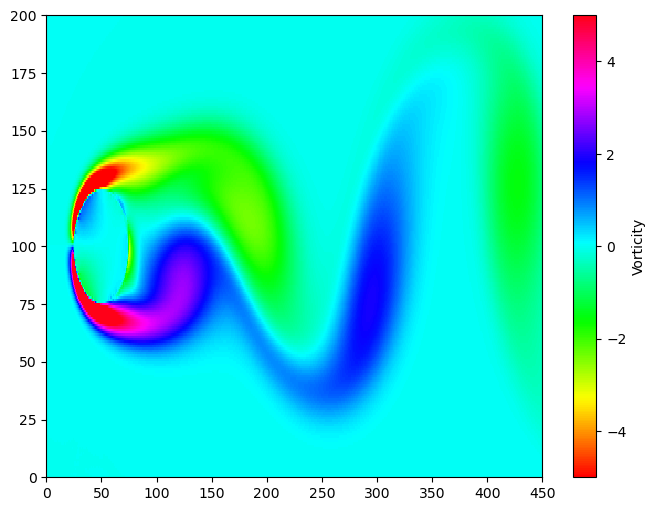

In [145]:
import matplotlib.pyplot as plt
koji=19

vort1=vort[:,koji]

vort1 = np.clip(vort1, -5,5)

fig, ax = plt.subplots(figsize=(8, 6))
y_os = np.linspace(0,200,200)
x_os = np.linspace(0,450,450)

c = ax.pcolormesh(x_os, y_os, vort1.reshape((-1,199)).T, cmap='hsv')
fig.colorbar(c, ax=ax, label='Vorticity')



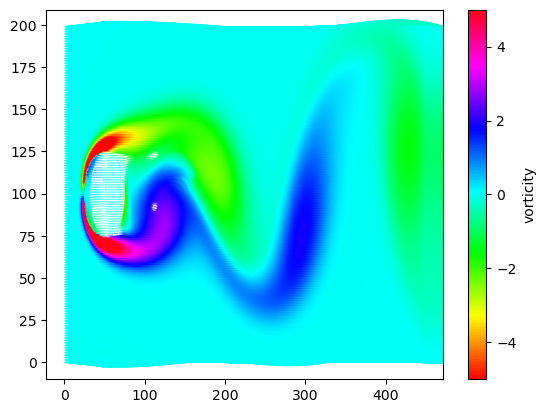

In [33]:
#quiver plot sa brzinama...

plt.figure()
x_os_2=np.repeat(x_os[:-1], 199); y_os_2=np.tile(y_os[:-1], 449)
q = plt.quiver(x_os_2, y_os_2, u[:,koji], v[:,koji], vort1, cmap='hsv', scale=10)
q.set_clim(-5, 5)
cb = plt.colorbar(q)
cb.set_label('vorticity')
plt.show()

In [147]:
N=vort.shape[1]-1
Z_v, L_v = DMD(vort[:,:N], vort[:,1:N+1], k=44)
print(L_v)

array([ 1.     +0.j     ,  0.97848+0.20635j,  0.97848-0.20635j,
        0.91484+0.40382j,  0.91484-0.40382j,  0.81182+0.5839j ,
        0.81182-0.5839j ,  0.67386+0.73886j,  0.67386-0.73886j,
        0.5069 +0.86201j,  0.5069 -0.86201j,  0.31811+0.94805j,
        0.31811-0.94805j,  0.11564+0.99329j,  0.11564-0.99329j,
       -0.09182+0.99578j, -0.09182-0.99578j, -0.29532+0.9554j ,
       -0.29532-0.9554j , -0.07062+0.j     , -0.33248+0.9301j ,
       -0.33248-0.9301j , -0.48611+0.8739j , -0.48611-0.8739j ,
       -0.52275+0.84985j, -0.52275-0.84985j, -0.65598+0.75478j,
       -0.65598-0.75478j, -0.69125+0.72246j, -0.69125-0.72246j,
       -0.79761+0.60317j, -0.79761-0.60317j, -0.99971+0.02394j,
       -0.99971-0.02394j, -0.97326+0.22972j, -0.97326-0.22972j,
       -0.98314+0.18286j, -0.98314-0.18286j, -0.90491+0.42561j,
       -0.90491-0.42561j, -0.92423+0.38179j, -0.92423-0.38179j,
       -0.82552+0.56431j, -0.82552-0.56431j])

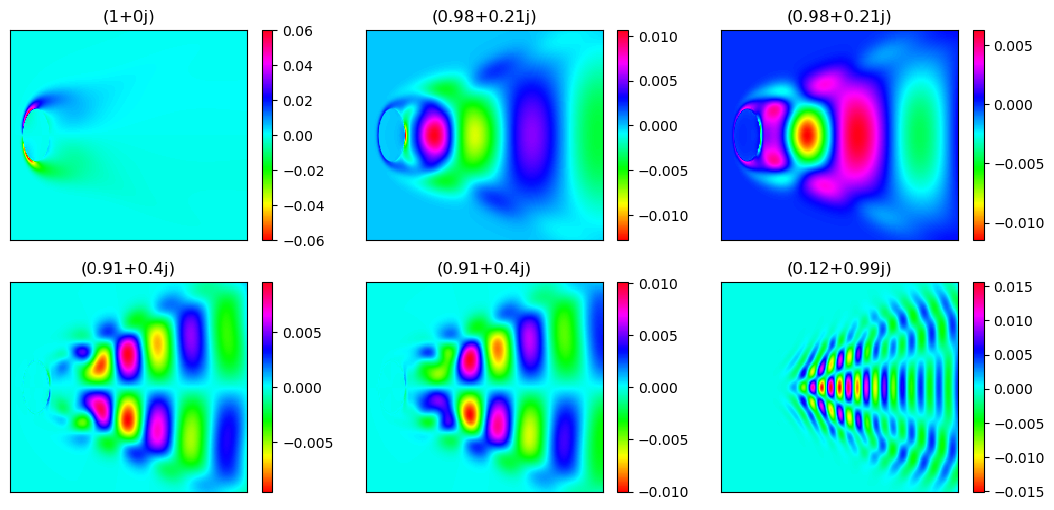

In [177]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))
koji_z=[0, 1, 1, 3, 3, 13]
for i in range(6):
    if(i not in [2,4]):
        c=axs[i//3,i%3].pcolormesh(x_os[:-1], y_os[:-1], np.real(Z_v[:,koji_z[i]]).reshape((-1,199)).T, cmap='hsv')
    else:
        c=axs[i//3,i%3].pcolormesh(x_os[:-1], y_os[:-1], np.imag(Z_v[:,koji_z[i]]).reshape((-1,199)).T, cmap='hsv')
    plt.colorbar(c, ax=axs[i//3, i%3], orientation='vertical')
    axs[i//3,i%3].set_xticks([])
    axs[i//3,i%3].set_yticks([])
    axs[i//3, i%3].set_title(np.around(L_v[koji_z[i]],2))
#c.set_clim(-0.01,0.01)

plt.show()

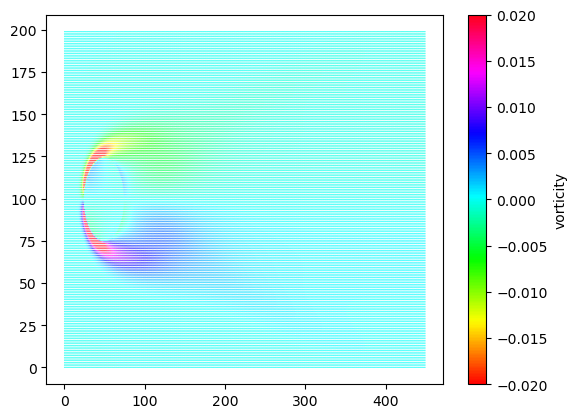

In [125]:
"""#sa obje brzine i vorticity
S = np.concatenate((u, v, vort), axis=0)
N=S.shape[1]
Z, L= DMD(S[:,:N-1], S[:,1:N], k=44)
Z.shape
L

plt.figure()
koji_z=0
q = plt.quiver(x_os_2, y_os_2, Z[:nx*ny,koji_z], Z[nx*ny:nx*ny*2,koji_z], np.real(Z[nx*ny*2:,koji_z]), cmap='hsv', scale=5)
q.set_clim(-0.02, 0.02)
cb = plt.colorbar(q)
cb.set_label('vorticity')
plt.show()

plt.figure()
q = plt.quiver(x_os_2, y_os_2, Z[:nx*ny,koji_z], Z[nx*ny:nx*ny*2,koji_z], np.imag(Z[nx*ny*2:,koji_z]), cmap='hsv', scale=1)
q.set_clim(-0.005, 0.005)
cb = plt.colorbar(q)
cb.set_label('vorticity')
plt.show()"""